In [1]:
import sys
sys.path.append('..')
from economic_brazil.coleta_dados.coleta_economic_brazil import dados_bcb
from economic_brazil.visualizacoes_graficas.codigos_graficos import Graficos
from economic_brazil.coleta_dados.economic_data_brazil import data_economic
from economic_brazil.processando_dados.data_processing import criando_dummy_covid, criando_defasagens,criando_mes_ano_dia,escalando_dados
from economic_brazil.processando_dados.estacionaridade import Estacionaridade
from economic_brazil.processando_dados.divisao_treino_teste import treino_test_dados,treino_teste_seies_temporal
from economic_brazil.treinamento.arima_treinamento import Arima
from economic_brazil.treinamento.modelos_treinamento import TreinamentoModelos
from economic_brazil.treinamento.treinamento_modelos_tuning import TimeSeriesModelTuner
from economic_brazil.analisando_modelos.regressao_conformal import ConformalRegressionPlotter


In [2]:
dados = data_economic()

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2000-01-01 to 2024-05-01
Freq: MS
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   selic                              293 non-null    float64
 1   IPCA-EX2                           293 non-null    float64
 2   IPCA-EX3                           293 non-null    float64
 3   IPCA-MS                            293 non-null    float64
 4   IPCA-MA                            293 non-null    float64
 5   IPCA-EX0                           293 non-null    float64
 6   IPCA-EX1                           293 non-null    float64
 7   IPCA-DP                            293 non-null    float64
 8   expectativas_inflacao              293 non-null    float64
 9   meta_inflacao                      293 non-null    float64
 10  inflacao_efetiva                   293 non-null    float64
 11  diferenca_meta_efetiva        

In [4]:
treino, teste = treino_test_dados(dados,data_divisao='2020-04-01',treino_teste=True)


O tamanho do treino e  (243, 17)
O tamanho do teste e  (50, 17)


# Tratamento

In [5]:
estacionaridade = Estacionaridade()

In [6]:
from sklearn.decomposition import PCA
train_covid = criando_dummy_covid(treino,inicio_periodo='2020-04-01', fim_periodo='2020-05-01')
train_est = estacionaridade.corrigindo_nao_estacionaridade(train_covid,'selic')
train_datas = criando_mes_ano_dia(train_est,mes=True,trimestre=True,dummy=True,coluns=['mes','trimestre'])
train_defas = criando_defasagens(train_datas,numero_defasagens=4)[4:]
index_train = train_defas.index
y_train = train_defas['selic'].values
x_train = train_defas.loc[:, train_defas.columns != 'selic'].values
x_train_scaler, scaler = escalando_dados(x_train,tipo="scaler")
pca = PCA(n_components=6)
x_train_pca = pca.fit_transform(x_train_scaler)


In [7]:
test_covid = criando_dummy_covid(teste,inicio_periodo='2020-04-01', fim_periodo='2020-05-01')
test_est = estacionaridade.corrigindo_nao_estacionaridade(test_covid,'selic')
test_data = criando_mes_ano_dia(test_est,mes=True,trimestre=True,dummy=True,coluns=['mes','trimestre'])
test_defas = criando_defasagens(test_data,numero_defasagens=4)[4:]
index = test_defas.index
y_test= test_defas['selic'].values
x_test = test_defas.loc[:, train_defas.columns != 'selic'].values
x_test_scaler = scaler.transform(x_test)
x_teste_pca = pca.transform(x_test_scaler)


In [8]:
modelo_arima = Arima()
arima_treinado = modelo_arima.treinar_arima(y_train,p=1,n=0, q=1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  238
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -88.571
Date:                Sun, 05 May 2024   AIC                            185.143
Time:                        13:14:16   BIC                            199.032
Sample:                             0   HQIC                           190.740
                                - 238                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.8612      5.496      2.158      0.031       1.090      22.633
ar.L1          0.9954      0.006    178.215      0.000       0.984       1.006
ma.L1          0.7326      0.028     26.179      0.0

In [9]:
treinamento_modelos = TreinamentoModelos(x_train_pca, y_train)
xgboost = treinamento_modelos.modelo_xgboost(learning_rate=0.1, random_state=0)

In [10]:
conformal = ConformalRegressionPlotter(xgboost, x_train_pca, x_teste_pca, y_train, y_test)

In [11]:
conformal.regressao_conformal()

Coverage and prediction interval width mean for CV+: 0.911, 13.513


(array([ 8.513395 ,  6.3805695,  5.8916607,  5.303134 ,  6.205444 ,
         7.418702 ,  7.339257 ,  4.816802 ,  4.851697 ,  5.0704403,
         8.350941 ,  8.518273 , 11.0086565,  9.737959 , 10.682429 ,
         9.566203 , 11.044112 , 11.600698 ,  9.666361 ,  9.930244 ,
        10.934099 , 12.976552 , 14.345377 , 11.906622 ,  7.0744314,
         6.831762 ,  8.330486 ,  8.100607 ,  6.6432166,  7.6862984,
         5.8277936,  7.824082 ,  6.800656 ,  8.899092 ,  8.895558 ,
         9.4643135,  6.9086637,  6.831762 ,  7.7827563,  8.110072 ,
         6.898684 ,  7.418702 ,  6.5727363,  6.520578 ,  4.5684013],
       dtype=float32),
 array([[[ 2.42684929],
         [16.32417831]],
 
        [[ 0.16029518],
         [13.72102013]],
 
        [[-0.40294344],
         [13.33587221]],
 
        [[-0.62764727],
         [12.51847441]],
 
        [[-0.05979561],
         [13.09173641]],
 
        [[ 0.92584896],
         [13.78061207]],
 
        [[ 0.54180681],
         [13.85860144]],
 
       

In [34]:
conformal.plot_prediction_intervals(index_train=index_train, index_test=index,  y_label="Selic", title="Predição Conformal Selic")

In [12]:
from typing import Union, Optional
from typing_extensions import TypedDict
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.metrics import regression_coverage_score
from mapie.subsample import Subsample 
from typing import List, Dict, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class ConformalAvaliandoMetodo:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred = {}
        self.y_pis = {}
        
    def regressao_conformal_estrategias(self,STRATEGIES: Dict=True):
        if STRATEGIES:
            Params = TypedDict("Params", {"method": str, "cv": Union[int, str, Subsample], "alpha": Optional[float]})
            STRATEGIES = {
                "naive": Params(method="naive"),
                "jackknife": Params(method="base", cv=-1),
                "jackknife_plus": Params(method="plus", cv=-1),
                "jackknife_minmax": Params(method="minmax", cv=-1),
                "cv": Params(method="base", cv=10),
                "cv_plus": Params(method="plus", cv=10),
                "cv_minmax": Params(method="minmax", cv=10),
                "jackknife_plus_ab": Params(method="plus", cv=Subsample(n_resamplings=50)),
                "jackknife_minmax_ab": Params(method="minmax", cv=Subsample(n_resamplings=50)),
                "conformalized_quantile_regression": Params(method="quantile", cv="split", alpha=0.05)
            }
            self.STRATEGIES = STRATEGIES
        else:
            self.STRATEGIES = STRATEGIES
        
        for strategy, params in STRATEGIES.items():
            if strategy == "conformalized_quantile_regression":
                mapie = MapieQuantileRegressor(self.model, **params)
                mapie.fit(self.X_train, self.y_train, random_state=1)
                self.y_pred[strategy], self.y_pis[strategy] = mapie.predict(self.X_test)
            else:  
                mapie = MapieRegressor(self.model, **params)
                mapie.fit(self.X_train, y_train)
                self.y_pred[strategy], self.y_pis[strategy] = mapie.predict(self.X_test, alpha=0.05)
        return self.y_pred, self.y_pis
    
    def _plot_1d_data(self,y_sigma,y_pred, y_pred_low, y_pred_up,ax=None,title=None):
        ax.set_xlabel("x") ; ax.set_ylabel("y")
        ax.fill_between(self.X_test, y_pred_low, y_pred_up, alpha=0.3)
        ax.scatter(self.X_train, self.y_train, color="red", alpha=0.3, label="Training data")
        ax.plot(self.X_test, self.y_test, color="gray", label="True confidence intervals")
        ax.plot(self.X_test, y_test - y_sigma, color="gray", ls="--")
        ax.plot(self.X_test, self.y_test + y_sigma, color="gray", ls="--")
        ax.plot(self.X_test, y_pred, color="blue", alpha=0.5, label="Prediction intervals")
        if title is not None:
            ax.set_title(title)
        ax.legend()
    
    def plotar_metodos_conformal(self,strategies:List=None,noise=0.5):
        if strategies is None:
            strategies = ["jackknife_plus", "jackknife_minmax", "cv_plus", "cv_minmax", "jackknife_plus_ab", "conformalized_quantile_regression"]
        n_figs = len(strategies)
        fig, axs = plt.subplots(3, 2, figsize=(9, 13))
        coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1], axs[2, 0], axs[2, 1]]
        for strategy, coord in zip(strategies, coords):
            self._plot_1d_data(
                self.X_train.ravel(),
                self.y_train.ravel(),
                self.X_test.ravel(),
                self.y_test.ravel(),
                np.full((self.X_test.shape[0]), 1.96*noise).ravel(),
                self.y_pred[strategy].ravel(),
                self.y_pis[strategy][:, 0, 0].ravel(),
                self.y_pis[strategy][:, 1, 0].ravel(),
                ax=coord,
                title=strategy
            )
    def metricas_comparacoes(self):
        return pd.DataFrame([
            [
                regression_coverage_score(
                    self.y_test, self.y_pis[strategy][:, 0, 0], self.y_pis[strategy][:, 1, 0]
                ),
                (
                    self.y_pis[strategy][:, 1, 0] - self.y_pis[strategy][:, 0, 0]
                ).mean()
            ] for strategy in self.STRATEGIES
        ], index=self.STRATEGIES, columns=["Coverage", "Width average"]).round(2)
        

In [13]:
#xgboost, x_train_scaler, x_test_scaler, y_train, y_test
testes_conformal = ConformalAvaliandoMetodo(xgboost, x_train_pca, x_teste_pca, y_train, y_test)

In [14]:
testes_conformal.regressao_conformal_estrategias()

ValueError: The base model does not seem to be accepted by MapieQuantileRegressor. 
Give a base model among: 
dict_keys(['GradientBoostingRegressor', 'QuantileRegressor', 'HistGradientBoostingRegressor', 'LGBMRegressor']) Or, add your base model to ``quantile_estimator_params``.

In [11]:
train_res = arima_treinado.resid

In [12]:
treinamento_modelos = TreinamentoModelos(x_train, y_train)

In [13]:
catboost = treinamento_modelos.modelo_catboost(learning_rate=0.1)
gradiente = treinamento_modelos.modelo_gradient_boosting(learning_rate=0.1, random_state=0)
xgboost = treinamento_modelos.modelo_xgboost(learning_rate=0.1, random_state=0)
regresao_linear = treinamento_modelos.modelo_regressao_linear(copy_X=True, n_jobs=None)

In [14]:
gradiente.fit(x_train, y_train)
xgboost.fit(x_train, y_train)
regresao_linear.fit(x_train, y_train)

LinearRegression()

In [15]:
catboost.fit(x_train, y_train)

0:	learn: 4.4989410	total: 110ms	remaining: 110ms
1:	learn: 4.4060173	total: 111ms	remaining: 0us


In [16]:
tunin = TimeSeriesModelTuner(catboost, dados,coluna='selic')

In [17]:
#write function for grid search for cast
parametros_cast = {'iterations': [2,3,4,100,1000], 'learning_rate': [0.1, 0.2, 0.3,0.5,1], 'depth': [2, 3, 4]}

In [18]:
# Executando os métodos
best_params_grid, best_score_grid = tunin.grid_search(parametros_cast)
best_params_random, best_score_random = tunin.random_search(parametros_cast)
best_params_bayes, best_score_bayes = tunin.bayesian_optimization(parametros_cast)

0:	learn: 2.6360220	total: 1.12ms	remaining: 1.12ms
1:	learn: 2.4879085	total: 1.52ms	remaining: 0us
0:	learn: 3.0933073	total: 279us	remaining: 279us
1:	learn: 2.9455269	total: 564us	remaining: 0us
0:	learn: 3.6609004	total: 337us	remaining: 337us
1:	learn: 3.4166366	total: 503us	remaining: 0us
0:	learn: 3.7634894	total: 1.46ms	remaining: 1.46ms
1:	learn: 3.5639967	total: 1.83ms	remaining: 0us
0:	learn: 3.9399981	total: 267us	remaining: 267us
1:	learn: 3.7162538	total: 564us	remaining: 0us
0:	learn: 2.4525760	total: 310us	remaining: 310us
1:	learn: 2.1937122	total: 579us	remaining: 0us
0:	learn: 2.8783437	total: 315us	remaining: 315us
1:	learn: 2.6162238	total: 531us	remaining: 0us
0:	learn: 3.3979483	total: 338us	remaining: 338us
1:	learn: 3.0546214	total: 566us	remaining: 0us
0:	learn: 3.5118239	total: 581us	remaining: 581us
1:	learn: 3.1484175	total: 869us	remaining: 0us
0:	learn: 3.6608520	total: 386us	remaining: 386us
1:	learn: 3.2680351	total: 756us	remaining: 0us
0:	learn: 2.27

In [19]:
modelo_cast = treinamento_modelos.treinar_catboost(interations=2,learning_rate=0.1,depth=3)

TypeError: TreinamentoModelos.treinar_catboost() got an unexpected keyword argument 'interations'

In [ ]:
y_hat = modelo_cast.predict(x_train)

In [ ]:
residuo = y_train - y_hat

In [ ]:
graficos = Graficos()

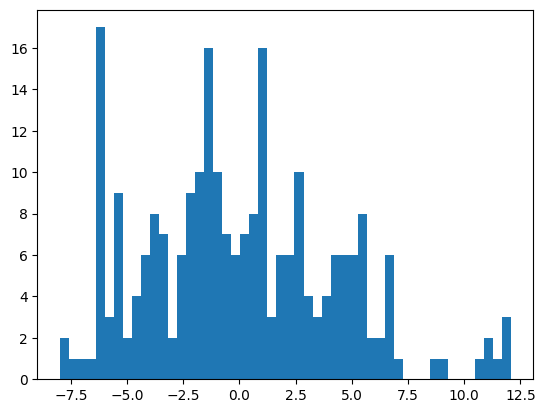

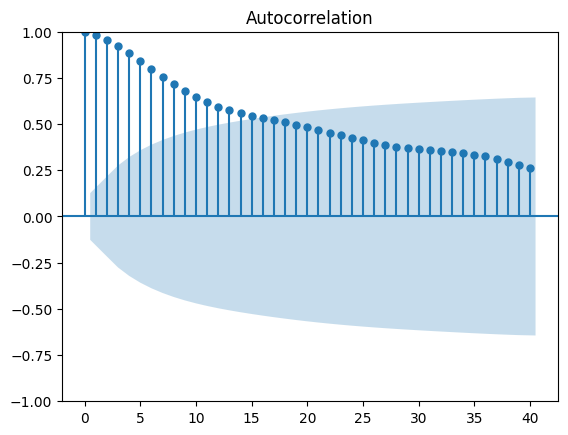

In [ ]:
graficos.plotar_residuos(y_train, y_hat)

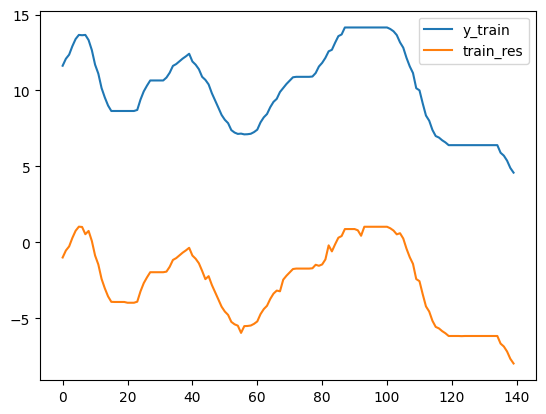

In [ ]:
# plot residuals and training data
import matplotlib.pyplot as plt
plt.plot(y_train[100:500], label='y_train')
plt.plot(residuo[100:500], label='train_res')
plt.legend()
plt.show()